### Импорты и вспомогательные функции

In [ ]:
!pip install pandas matplotlib seaborn natasha scikit-learn evaluate

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 126.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5c2d606580957e55aa0a433295ef963b65cd689e7e5fbf502c7d3f074b131cce
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=9b1157c72776a15d7f29c02d917a03016942437b7f8be84ebed450899acee06c
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
import torch
import re
import pathlib
import os
import unicodedata
import accelerate


In [ ]:
def clean_text(text):
    """Очистка текста"""

    # Проверка на NaN/None
    if not isinstance(text, str):
        return ""

    # 1. Нижний регистр
    text = text.lower()

    # 2. Удаление эмодзи и спец символов (оставляем буквы, цифры, пунктуацию, пробелы)
    cleaned = []
    for char in text:
        category = unicodedata.category(char)
        if category[0] in ['L', 'N', 'P', 'Z']:
            cleaned.append(char)
    text = ''.join(cleaned)

    # 3. Защита многоточия
    text = text.replace('...', '__ELLIPSIS__')

    # 4. Уменьшение повторяющихся знаков до одного
    text = re.sub(r'([!?;:,\-—–])\1+', r'\1', text)

    # 5. Восстановление многоточия
    text = text.replace('__ELLIPSIS__', '...')

    # 6. Удаление лишних пробелов
    text = re.sub(r'\s{2,}', ' ', text)

    # 7. Удаление пробелов в начале/конце
    text = text.strip()

    return text


In [ ]:
def combine_text_with_src(df, text_col='text', src_col='src', output_col='text'):
    """
    Склеивает текст из двух столбцов по шаблону:
    [SRC] текст из source [TEXT] текст из text

    Args:
        df (pd.DataFrame): Исходный датафрейм
        text_col (str): Имя столбца с текстом
        src_col (str): Имя столбца с источником
        output_col (str): Имя выходного столбца

    Returns:
        pd.DataFrame: DataFrame с новым столбцом
    """

    # Проверка наличия столбцов
    if text_col not in df.columns:
        raise ValueError(f"Столбец '{text_col}' не найден")
    if src_col not in df.columns:
        raise ValueError(f"Столбец '{src_col}' не найден")

    # Склеиваем строки
    df[output_col] = "[SRC] " + df[src_col].astype(str) + " [TEXT] " + df[text_col].astype(str)

    return df


In [ ]:
global check_tokenizer
check_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
def check_token_lengths(text):
    tokens = check_tokenizer(text, return_tensors="pt", truncation=False)
    return len(tokens["input_ids"][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def print_token_stats(lengths):
    print(f"Минимальное количество токенов: {np.min(lengths)}")
    print(f"Максимальное количество токенов: {np.max(lengths)}")
    print(f"Среднее количество токенов: {np.mean(lengths):.2f}")
    print(f"Медиана количества токенов: {np.median(lengths):.2f}")
    print(f"Стандартное отклонение: {np.std(lengths):.2f}")
    print(f"25-й перцентиль: {np.percentile(lengths, 25):.2f}")
    print(f"75-й перцентиль: {np.percentile(lengths, 75):.2f}")
    print(f"Общее количество комментариев: {len(lengths)}")


In [ ]:
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # Считаем macro F1 по ТЗ
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")


## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = pathlib.Path(os.getcwd()).parent.resolve()
data_path = os.path.join(folder_path, 'data')
file_path = os.path.join(data_path, 'raw', 'train.csv')
file_path = '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/data/raw/train.csv'
print(folder_path)
print(data_path)
print(file_path)

/
/data
/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/data/raw/train.csv


In [ ]:
try:
    df = pd.read_csv(file_path)
    print("Файл успешно загружен!")
except:
    df = pd.read_csv(file_path, sep=';')
    print("Файл загружен с разделителем ';'")

print(f"Размер датасета: {df.shape}")
display(df.head())

Файл успешно загружен!
Размер датасета: (232366, 4)


,ID,text,src,label
0,26739,smaller than in description.,rureviews,0
1,198426,Слева от меня Алексей Ильмухин. Путешественник...,rusentiment,1
2,172615,"Ребёнок в садик отходил год, из них пол года п...",geo,2
3,246532,Замерзла на -15,perekrestok,2
4,209852,"Как всегда, название не соответствует истинном...",kinopoisk,0


In [ ]:
preprocessed_lengths = df['text'][0:100000].apply(check_token_lengths)

In [ ]:
print_token_stats(preprocessed_lengths)

Минимальное количество токенов: 3
Максимальное количество токенов: 915
Среднее количество токенов: 79.59
Медиана количества токенов: 43.00
Стандартное отклонение: 83.34
25-й перцентиль: 19.00
75-й перцентиль: 114.00
Общее количество комментариев: 100000


### (Предыдущая версия предобработки текста)

In [ ]:
df_clean = df[['text', 'label']].copy()

### (Новая версия)

In [ ]:
df_clean = df.copy()
df_clean['text'] = df['text'].apply(clean_text)
df_clean = combine_text_with_src(df_clean)


In [ ]:
df_clean

,ID,text,src,label
0,26739,[SRC] rureviews [TEXT] smaller than in descrip...,rureviews,0
1,198426,[SRC] rusentiment [TEXT] слева от меня алексей...,rusentiment,1
2,172615,"[SRC] geo [TEXT] ребёнок в садик отходил год, ...",geo,2
3,246532,[SRC] perekrestok [TEXT] замерзла на -15,perekrestok,2
4,209852,"[SRC] kinopoisk [TEXT] как всегда, название не...",kinopoisk,0
...,...,...,...,...
232361,119879,"[SRC] anime [TEXT] 4 серии, ну и немного пятую...",anime,2
232362,259178,[SRC] perekrestok [TEXT] слишком уксусный вкус,perekrestok,0
232363,131932,"[SRC] geo [TEXT] отличное расположение, неплох...",geo,0
232364,146867,[SRC] geo [TEXT] отличный центр! пришел на леч...,geo,1


In [ ]:
processed_lengths = df_clean['text'].apply(check_token_lengths)

In [ ]:
print_token_stats(processed_lengths)

Минимальное количество токенов: 13
Максимальное количество токенов: 534
Среднее количество токенов: 90.32
Медиана количества токенов: 54.00
Стандартное отклонение: 82.34
25-й перцентиль: 31.00
75-й перцентиль: 122.00
Общее количество комментариев: 232366


### Графики

In [ ]:
df_clean = df_clean.dropna(subset=['text'])
df_clean['label'] = df_clean['label'].astype(int) # Убеждаемся, что инты

print(f"Размер датасета: {len(df_clean)}")
print(df_clean.head())

Размер датасета: 232366
       ID                                               text          src  \
0   26739  [SRC] rureviews [TEXT] smaller than in descrip...    rureviews   
1  198426  [SRC] rusentiment [TEXT] слева от меня алексей...  rusentiment   
2  172615  [SRC] geo [TEXT] ребёнок в садик отходил год, ...          geo   
3  246532           [SRC] perekrestok [TEXT] замерзла на -15  perekrestok   
4  209852  [SRC] kinopoisk [TEXT] как всегда, название не...    kinopoisk   

   label  
0      0  
1      1  
2      2  
3      2  
4      0  


<Axes: >

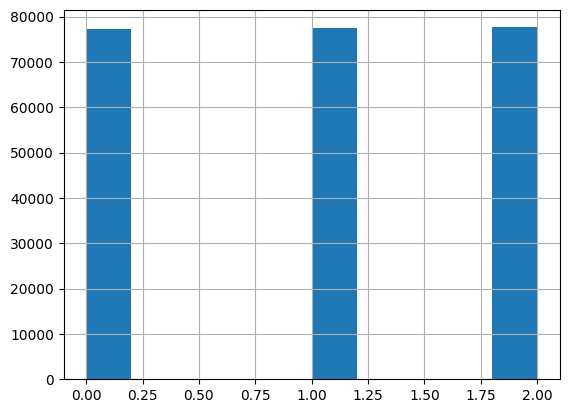

In [ ]:
df['label'].hist()

## Разбиение и создание датасета

In [ ]:
train_df, val_df = train_test_split(
    df_clean, test_size=0.08, random_state=42, stratify=df_clean['label']
)

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(val_df)
})

## Создание и настройка модели ruBert-tiny

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Inference device: {device}")

Inference device: cuda


## cointegrated/rubert-tiny2

In [ ]:
model_cointegrated = "cointegrated/rubert-tiny2"
tokenizer_cointegrated = AutoTokenizer.from_pretrained(model_cointegrated)

# ИНИЦИАЛИЗИРУЕМ МОДЕЛЬ ПОД 3 КЛАССА
id2label = {0: "neutral", 1: "positive", 2: "negative"}
label2id = {"neutral": 0, "positive": 1, "negative": 2}

In [ ]:
def preprocess_function_cointegrated(examples):
    return tokenizer_cointegrated(examples["text"], truncation=True, max_length=512)

tokenized_datasets_cointegrated = dataset.map(preprocess_function_cointegrated, batched=True)
data_collator_cointegrated = DataCollatorWithPadding(tokenizer=tokenizer_cointegrated)

Map:   0%|          | 0/213776 [00:00<?, ? examples/s]

Map:   0%|          | 0/18590 [00:00<?, ? examples/s]

In [ ]:
model_cointegrated = AutoModelForSequenceClassification.from_pretrained(
    model_cointegrated,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_cointegrated = TrainingArguments(
    output_dir="checkpoints_full_finetune",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="none"
)

In [ ]:
trainer_cointegrated = Trainer(
    model=model_cointegrated,
    args=training_args_cointegrated,
    train_dataset=tokenized_datasets_cointegrated["train"],
    eval_dataset=tokenized_datasets_cointegrated["test"],
    processing_class=tokenizer_cointegrated,
    data_collator=data_collator_cointegrated,
    compute_metrics=compute_metrics,
)

### Обучение и валидация модели

In [ ]:
print("\nНачинаем ПОЛНОЕ обучение (Full Fine-Tuning)")
trainer_cointegrated.train()


Начинаем ПОЛНОЕ обучение (Full Fine-Tuning)


Epoch,Training Loss,Validation Loss,F1
1,0.614600,0.588859,0.735072
2,0.572400,0.575014,0.740057
3,0.549400,0.566772,0.747520


TrainOutput(global_step=10023, training_loss=0.6027162095737543, metrics={'train_runtime': 2572.0766, 'train_samples_per_second': 249.342, 'train_steps_per_second': 3.897, 'total_flos': 3073465728180576.0, 'train_loss': 0.6027162095737543, 'epoch': 3.0})

In [ ]:
print("\nСчитаем итоговые метрики на валидации")
eval_result_cointegrated = trainer_cointegrated.evaluate()
print(f"Baseline Macro-F1: {eval_result_cointegrated['eval_f1']:.4f}")


Считаем итоговые метрики на валидации


Baseline Macro-F1: 0.7475


F1-macro на валидации: 0.7475

###Сохранение модели

In [ ]:
trainer_cointegrated.save_model("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART")
tokenizer_cointegrated.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART")

('/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated_ART/tokenizer.json')